#                                                 1.Ödev Eye Disease Detection Dataset  

1.Ödev kapsamında Eye Disease Detection Dataset isimli veri kümesinin içinden Train isimli klasörün 
içerisine girip NORMAL, DRUSEN, DME, ve CNV kategorileri için rastgele 200’er görüntüyü python kullanarak bir klasöre kopyalayıp kendi datasetimi oluşturdum.Bu bölümde görsel üzerinde yapılan işlemleri adım adım inceleyeceğiz:

In [46]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

#  Görsel Yolu
image_path = r'C:\Users\USER\Desktop\image\DME-671384-9.jpeg'  

#  Çıkış Klasörü
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")
output_folder = os.path.join(desktop_path, "image_eye")

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Görüntüyü Oku
image = cv2.imread(image_path)
if image is None:
    print(" Görüntü Yüklenemedi! Yolu Kontrol Et.")
    exit()
else:
    print(" Görüntü Yüklendi!")


 Görüntü Yüklendi!


### 🔹 1️⃣ Görüntü İşleme: Gri Tonlama ve CLAHE 
İlk adımda, görseli gri tonlamaya çeviriyorum. Bu işlem, renk bilgilerini kaybedip yalnızca parlaklık bilgisini bırakır. Ardından, kontrastı artırmak için CLAHE işlemi uyguluyorum.

In [48]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
contrast_enhanced = clahe.apply(gray)

### 🔹 2️⃣ Gaussian Blur
Gürültüyü azaltmak ve görselin daha pürüzsüz görünmesini sağlamak amacıyla (3, 3) boyutunda bir çekirdek kullanılarak, 
hafif bir yumuşatma uyguladım.

In [18]:
blurred = cv2.GaussianBlur(contrast_enhanced, (3, 3), 0)

### 🔹 3️⃣ Eşikleme
Aşağıdaki kod bloğunda belirlenen eşik değeri olan 127'nin altında kalan pikseller siyah (0), üstündekiler beyaz (255) yapılır.

In [24]:
_, thresholded = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY)

### 🔹 4️⃣ Bitwise: Orijinal + Threshold Maskesi
Threshold ile oluşturulan siyah-beyaz maske, orijinal görüntüye uygulanır.Sadece maskede beyaz kalan bölgeler görüntüde tutulur, 
diğer tüm alanlar karartılır.

In [27]:
bitwise_combined = cv2.bitwise_and(image, image, mask=thresholded)

### 🔹 5️⃣ Kenar Tespiti: Dalgaya Dayanıklı Özel Filtre (Benim Filtrem)
Bu kod bloğu, görselden önemli yapısal bilgileri çıkarmak için bir özel kenar tespit filtresi uygular. 
Aşamalar:
1-Önce özel bir kenar filtresi tanımlanır.
2-Görüntü gri tonlamaya çevrilir.
3-Filtre bu gri görüntüye uygulanarak kenar haritası elde edilir.

Merkezdeki '4' değeri, çevresindeki piksellerin toplam değerini azaltarak yüksek kontrastlı alanları (kenarları) öne çıkarır.-1 değerleri, kenar bilgilerini çeker; böylece merkez piksel ile çevresi arasında fark varsa bu fark vurgulanır.Bu filtre, özellikle yatay desenleri bastırır, dikey kenarları vurgular. Bu, retina yapısındaki bazı dikey damarları veya yapısal detayları daha belirgin hale getirmede etkili olabilir.

In [32]:
custom_filter = np.array([
    [ 0, -1,  0],
    [-1,  4, -1],
    [ 0,  0,  0]
], dtype=np.float32)

bitwise_gray = cv2.cvtColor(bitwise_combined, cv2.COLOR_BGR2GRAY)
edges = cv2.filter2D(bitwise_gray, -1, custom_filter)

### 🔹 6️⃣ Morfolojik İşlem: Kenarları Genişletme & Gürültü Temizleme
Bu blokta 3x3 boyutunda bir yapısal eleman (kernel) tanımladım.Ardından Closing işlemi uyguladım.Closing işlemi önce dilatasyon (genişletme) sonra erozyon (küçültme) uygular.Closing işlemi kopuk çizgiyi düzleştirip birleştirir, içindeki küçük boşlukları doldurur, görüntüyü daha düzgün ve anlaşılır hale getirir.

In [35]:
kernel = np.ones((3, 3), np.uint8)
edges_morph_close = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

### 🔹 Sonuçların Kaydedilmesi ve Görselleştirilmesi

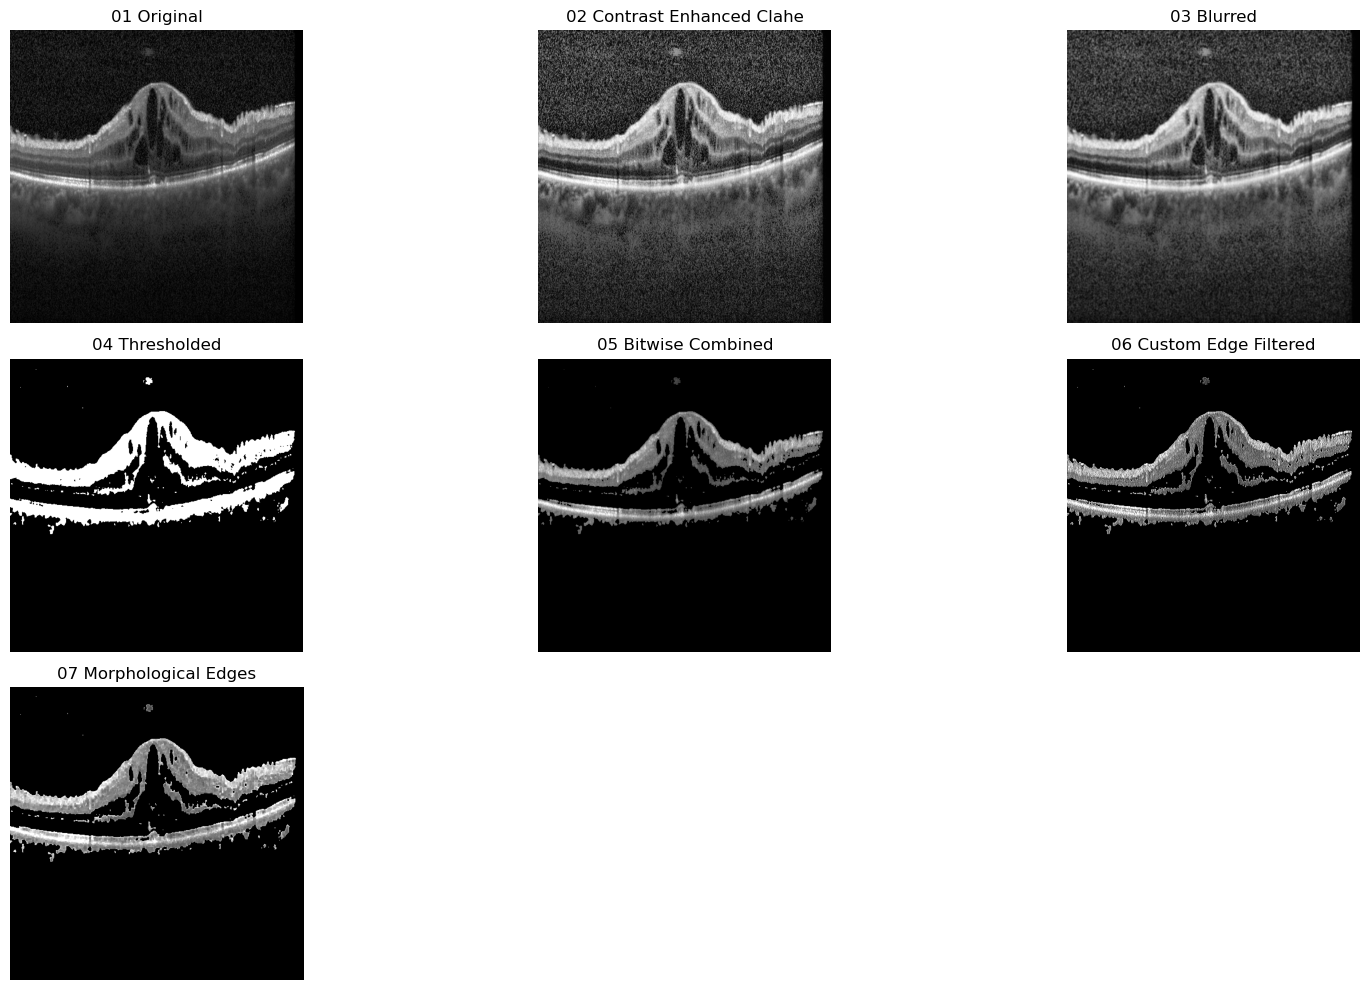

Çıktılar 'C:\Users\USER\Desktop\image_eye' klasörüne kaydedildi.


In [50]:
#  Sonuçları Kaydet
result_images = {
    "01_original": image,
    "02_contrast_enhanced_CLAHE": contrast_enhanced,
    "03_blurred": blurred,
    "04_thresholded": thresholded,
    "05_bitwise_combined": bitwise_combined,
    "06_custom_edge_filtered": edges,
    "07_morphological_edges": edges_morph_close,
   
}

for name, img in result_images.items():
    output_path = os.path.join(output_folder, f"{name}.png")
    cv2.imwrite(output_path, img)

# Sonuçları Göster
plt.figure(figsize=(16, 10))
for i, (name, img) in enumerate(result_images.items()):
    plt.subplot(3, 3, i + 1)
    plt.imshow(img, cmap="gray" if len(img.shape) == 2 else None)
    plt.title(name.replace("_", " ").title())
    plt.axis("off")
plt.tight_layout()
plt.show()

print(f"Çıktılar '{output_folder}' klasörüne kaydedildi.")


# Oluşturulan Hiyerarşinin Tüm Dataset'e Uygulanması
Bu aşamada, geliştirdiğim özgün görüntü işleme hiyerarşisi, NORMAL, DRUSEN, DME ve CNV olmak üzere dört sınıfa ait tüm görüntülere uygulanmıştır. Her bir görüntü, aşağıdaki sıralı adımlar doğrultusunda işlenmiştir:

-Grayscale dönüşümü ve CLAHE ile kontrast artırımı

-Gaussian Blur uygulaması

-Thresholding (eşikleme) işlemi

-Bitwise AND işlemi ile maskeleme

-Özel kenar tespit filtresi

-Morfolojik Closing işlemi

-İşlenmiş görüntülerin kaydedilmesi

Her bir kategori için işlenmiş görüntüler ayrı klasörlerde saklanmıştır. Bu sayede, transfer learning ile sınıflandırma yapılmadan önce işlenmiş veri seti hazır hale getirilmiştir.



 NORMAL kategorisi işleniyor...


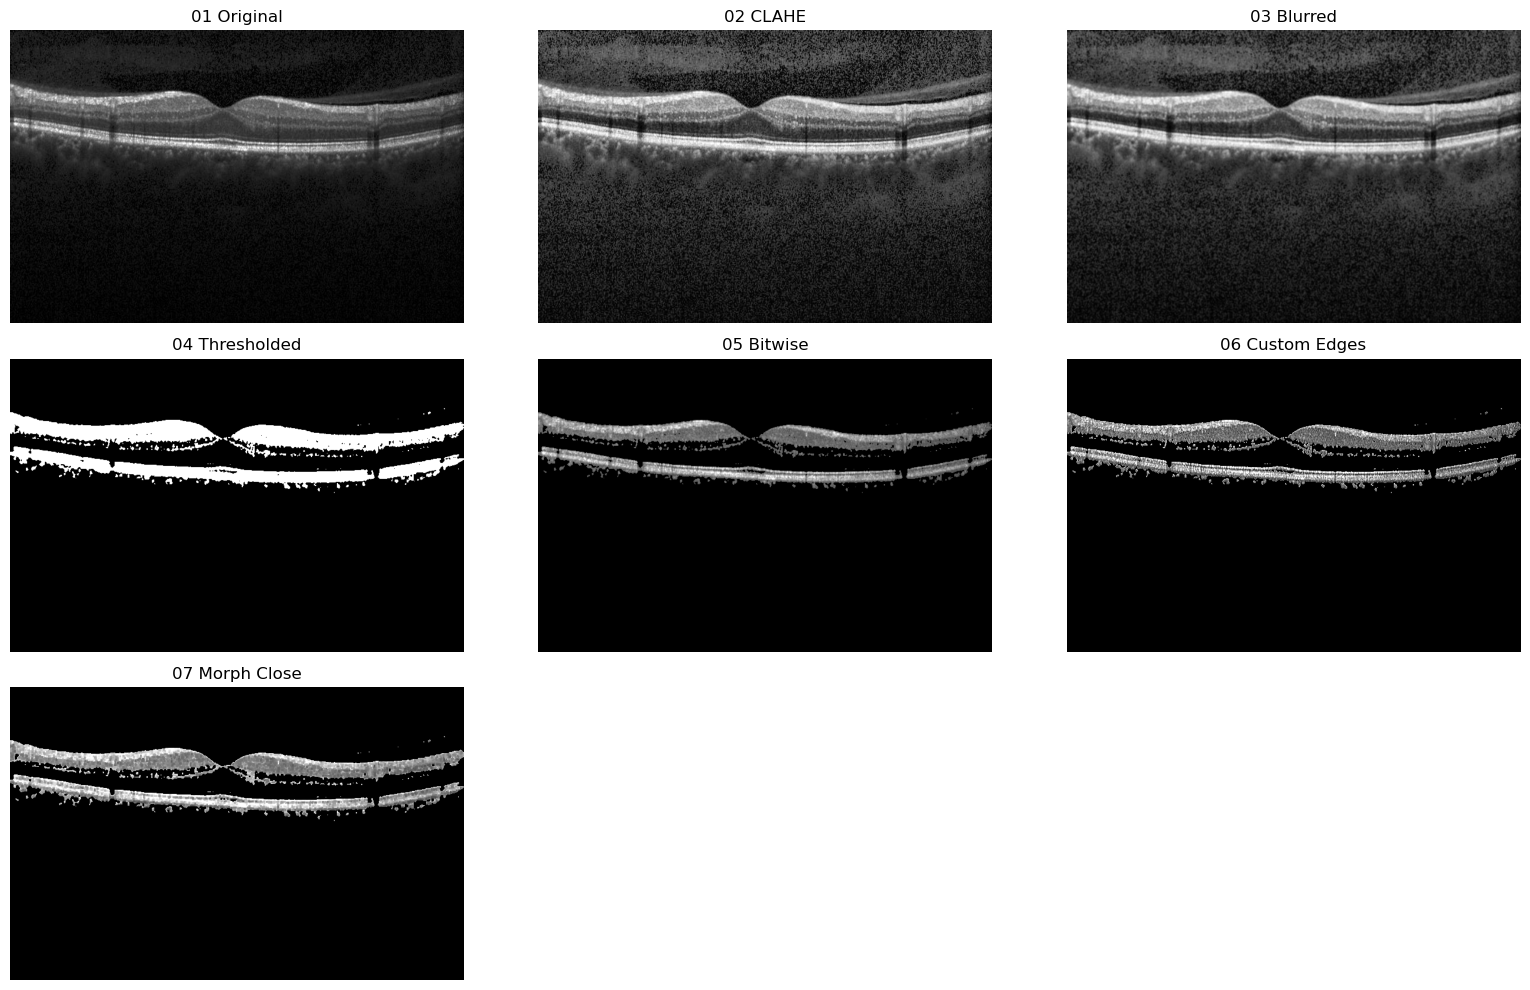

 NORMAL kategorisi tamamlandı!

 DRUSEN kategorisi işleniyor...
 DRUSEN kategorisi tamamlandı!

 DME kategorisi işleniyor...
 DME kategorisi tamamlandı!

 CNV kategorisi işleniyor...
 CNV kategorisi tamamlandı!


In [59]:
show_visualization = True  # sadece ilk kategori ve ilk görsel için True olacak

for category in categories:
    input_folder = os.path.join(dataset_path, category)
    output_folder = os.path.join(output_root, category)

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    print(f"\n {category} kategorisi işleniyor...")

    for index, filename in enumerate(os.listdir(input_folder)):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(input_folder, filename)
            image = cv2.imread(image_path)

            if image is None:
                print(f" {filename} yüklenemedi.")
                continue

            # İşlem adımları

            # Renk uzayı işlemi: Grayscale + CLAHE
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            contrast_enhanced = clahe.apply(gray)
            
            # Gaussian Blur
            blurred = cv2.GaussianBlur(contrast_enhanced, (3, 3), 0)
            
            #Thresholding
            _, thresholded = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY)
            
            #Bitwise Masking
            bitwise_combined = cv2.bitwise_and(image, image, mask=thresholded)
            
            #Özel Kenar Tespit Filtresi
            custom_filter = np.array([
                [ 0, -1,  0],
                [-1,  4, -1],
                [ 0,  0,  0]
            ], dtype=np.float32)

            bitwise_gray = cv2.cvtColor(bitwise_combined, cv2.COLOR_BGR2GRAY)
            edges = cv2.filter2D(bitwise_gray, -1, custom_filter)
            
            #Morfolojik İşlem (Closing)
            kernel = np.ones((3, 3), np.uint8)
            edges_morph_close = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

            # Kaydet
            output_path = os.path.join(output_folder, f"processed_{filename}")
            cv2.imwrite(output_path, edges_morph_close)

            #  Sadece ilk kategori ve ilk görsel için görselleştir
            if show_visualization:
                result_images = {
                    "01_Original": image,
                    "02_CLAHE": contrast_enhanced,
                    "03_Blurred": blurred,
                    "04_Thresholded": thresholded,
                    "05_Bitwise": bitwise_combined,
                    "06_Custom_Edges": edges,
                    "07_Morph_Close": edges_morph_close,
                }

                plt.figure(figsize=(16, 10))
                for i, (name, img) in enumerate(result_images.items()):
                    plt.subplot(3, 3, i + 1)
                    plt.imshow(img, cmap="gray" if len(img.shape) == 2 else None)
                    plt.title(name.replace("_", " "))
                    plt.axis("off")
                plt.tight_layout()
                plt.show()

                show_visualization = False  

    print(f" {category} kategorisi tamamlandı!")
